--2023-06-28 00:57:07--  https://samsclass.info/129S/proj/content2.zip
Resolving samsclass.info (samsclass.info)... 172.67.219.198, 104.21.17.27, 2606:4700:3036::ac43:dbc6, ...
Connecting to samsclass.info (samsclass.info)|172.67.219.198|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 268964 (263K) [application/zip]
Saving to: ‘content2.zip’

content2.zip        100%[===================>] 262.66K  --.-KB/s    in 0.04s   

2023-06-28 00:57:08 (6.82 MB/s) - ‘content2.zip’ saved [268964/268964]

Archive:  content2.zip
   creating: content2/
  inflating: content2/.DS_Store      
  inflating: __MACOSX/content2/._.DS_Store  
   creating: content2/extracted_letter_images/
  inflating: content2/extracted_letter_images/.DS_Store  
  inflating: __MACOSX/content2/extracted_letter_images/._.DS_Store  
   creating: content2/extracted_letter_images/R/
   creating: content2/extracted_letter_images/U/
   creating: content2/extracted_letter_images/9/
   creating: content2/extr

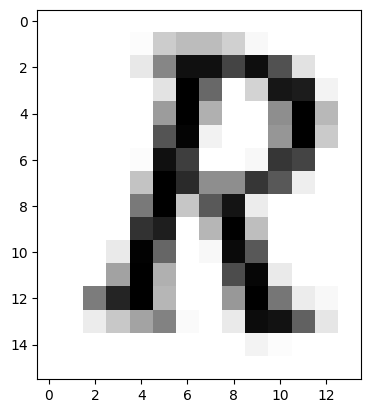

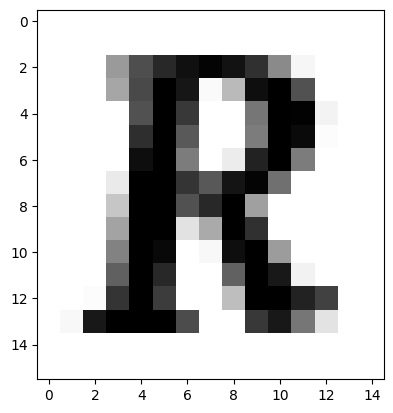

In [2]:
!wget https://samsclass.info/129S/proj/content2.zip
!unzip content2.zip
!wget https://samsclass.info/129S/proj/helpers.py.zip
!unzip helpers.py.zip

import matplotlib.pyplot as plt
import imageio as iio

image = iio.v2.imread("content2/extracted_letter_images/R/001099.png")
plt.imshow(image, cmap='gray')
plt.show()

image = iio.v2.imread("content2/extracted_letter_images/R/000387.png")
plt.imshow(image, cmap='gray')
plt.show()

In [3]:
import cv2
import pickle
import os.path
import numpy as np
from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from helpers import resize_to_fit


LETTER_IMAGES_FOLDER = "content2/extracted_letter_images"
MODEL_FILENAME = "captcha_model.hdf5"
MODEL_LABELS_FILENAME = "model_labels.dat"


# initialize the data and labels
data = []
labels = []

# loop over the input images
for image_file in paths.list_images(LETTER_IMAGES_FOLDER):
    # Load the image and convert it to grayscale
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Resize the letter so it fits in a 20x20 pixel box
    image = resize_to_fit(image, 20, 20)

    # Add a third channel dimension to the image to make Keras happy
    image = np.expand_dims(image, axis=2)

    # Grab the name of the letter based on the folder it was in
    label = image_file.split(os.path.sep)[-2]

    # Add the letter image and it's label to our training data
    data.append(image)
    labels.append(label)


# scale the raw pixel intensities to the range [0, 1] (this improves training)
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

# Split the training data into separate train and test sets
(X_train, X_test, Y_train, Y_test) = train_test_split(data, labels, test_size=0.25, random_state=0)

# Convert the labels (letters) into one-hot encodings that Keras can work with
lb = LabelBinarizer().fit(Y_train)
Y_train = lb.transform(Y_train)
Y_test = lb.transform(Y_test)

# Save the mapping from labels to one-hot encodings.
# We'll need this later when we use the model to decode what it's predictions mean
with open(MODEL_LABELS_FILENAME, "wb") as f:
    pickle.dump(lb, f)

In [5]:
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Flatten, Dense

model = Sequential()

# First convolutional layer with max pooling
model.add(Conv2D(20, (5, 5), padding="same", input_shape=(20, 20, 1), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Second convolutional layer with max pooling
model.add(Conv2D(50, (5, 5), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Hidden layer with 500 nodes
model.add(Flatten())
model.add(Dense(100, activation="relu"))
# model.add(Dense(500, activation="relu"))

# Output layer with 32 nodes (one for each possible letter/number we predict)
model.add(Dense(32, activation="softmax"))

# Ask Keras to build the TensorFlow model behind the scenes
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.summary()

model.fit(X_train, Y_train, validation_data=(X_test, Y_test), batch_size=32, epochs=10, verbose=2)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 20, 20, 20)        520       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 10, 10, 20)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 10, 10, 50)        25050     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 5, 50)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1250)              0         
                                                                 
 dense_2 (Dense)             (None, 100)              